In [3]:
import os 
from tqdm.autonotebook import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import pandas as pd
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from sklearn.model_selection import train_test_split
from torch.autograd import Variable

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', font_scale=1.4)

import time
import warnings
warnings.filterwarnings('ignore')

rescale_size = 244
batch_size = 8

In [6]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c journey-springfield

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists
 99% 518M/521M [00:24<00:00, 23.1MB/s]
100% 521M/521M [00:24<00:00, 22.4MB/s]


In [9]:
! unzip journey-springfield.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: train/simpsons_dataset/moe_szyslak/pic_1025.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1026.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1027.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1028.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1029.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1030.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1031.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1032.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1033.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1034.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1035.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1036.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1037.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1038.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pi

In [10]:
device = torch.device('cuda:0') if torch.cuda.is_available else torch.device('cpu')
device

device(type='cuda', index=0)

In [11]:
transform = transforms.Compose([
        transforms.Resize((int(rescale_size * 1.25), int(rescale_size * 1.25))),
        transforms.RandomCrop(rescale_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

full_data = datasets.ImageFolder(root='train/simpsons_dataset', 
                                    transform=transform)

train_idx, valid_idx = train_test_split(list(range(len(full_data))), train_size=0.8)
dataset = {
    'train': torch.utils.data.Subset(full_data, train_idx),
    'val': torch.utils.data.Subset(full_data, valid_idx)
}

dataloaders = {
    'train': torch.utils.data.DataLoader(
        dataset=dataset['train'], batch_size=batch_size, shuffle=True, num_workers=2
    ),
    'val': torch.utils.data.DataLoader(
        dataset=dataset['val'], batch_size=batch_size, shuffle=False, num_workers=2
    ),
}

dataset_sizes = {x: len(dataset[x]) for x in ['train', 'val']}
class_names = np.array(full_data.classes)

print('There are such classes in full data:\n')
for i, el in enumerate(class_names):
    print(f'{i+1}. {el}')

print('\nDatasets sizes:', dataset_sizes, '\n')

There are such classes in full data:

1. abraham_grampa_simpson
2. agnes_skinner
3. apu_nahasapeemapetilon
4. barney_gumble
5. bart_simpson
6. carl_carlson
7. charles_montgomery_burns
8. chief_wiggum
9. cletus_spuckler
10. comic_book_guy
11. disco_stu
12. edna_krabappel
13. fat_tony
14. gil
15. groundskeeper_willie
16. homer_simpson
17. kent_brockman
18. krusty_the_clown
19. lenny_leonard
20. lionel_hutz
21. lisa_simpson
22. maggie_simpson
23. marge_simpson
24. martin_prince
25. mayor_quimby
26. milhouse_van_houten
27. miss_hoover
28. moe_szyslak
29. ned_flanders
30. nelson_muntz
31. otto_mann
32. patty_bouvier
33. principal_skinner
34. professor_john_frink
35. rainier_wolfcastle
36. ralph_wiggum
37. selma_bouvier
38. sideshow_bob
39. sideshow_mel
40. snake_jailbird
41. troy_mcclure
42. waylon_smithers

Datasets sizes: {'train': 16746, 'val': 4187} 



In [12]:
transform = transforms.Compose([
        transforms.Resize((int(rescale_size * 1.25), int(rescale_size * 1.25))),
        transforms.RandomCrop(rescale_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

dataset_test = torchvision.datasets.ImageFolder(
    root='testset',
    transform=transform
)
dataloader_test = torch.utils.data.DataLoader(dataset_test, shuffle=False, batch_size=batch_size)
test_filenames = [fn[0].split('/')[-1] for fn in dataset_test.imgs]

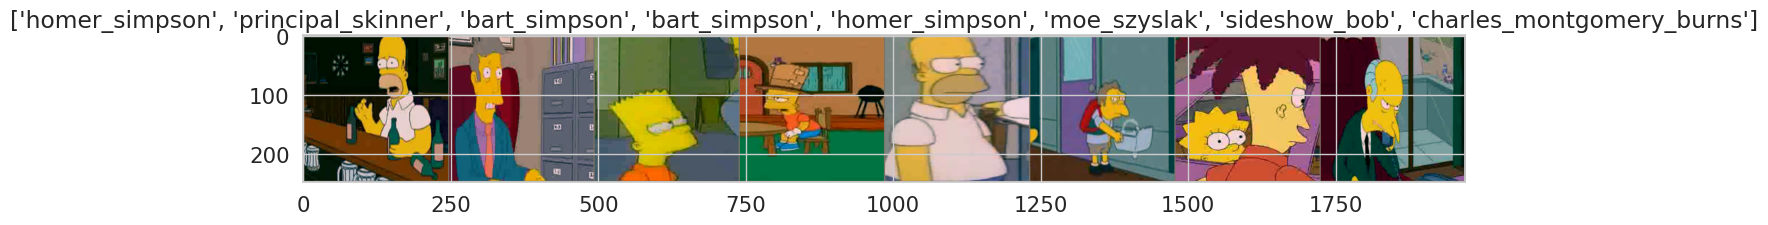

In [13]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.299, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    plt.figure(figsize=(15, 12))
    plt.imshow(inp)

    if title is not None:
        plt.title(title)   


inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [14]:
for i in dataloaders['train']:
    print(i[0][0])
    break

tensor([[[-0.3027, -0.3541, -0.3541,  ..., -1.2788, -1.3815, -1.4329],
         [-0.3027, -0.4397, -0.4397,  ..., -0.9705, -0.9877, -1.2274],
         [-0.4739, -0.6794, -0.6794,  ..., -0.5938, -0.4054, -0.8335],
         ...,
         [ 0.0569,  0.1426,  0.1426,  ...,  0.0741,  0.0741,  0.0741],
         [ 0.0569,  0.1426,  0.1426,  ...,  0.0741,  0.0741,  0.0912],
         [ 0.0569,  0.1426,  0.1426,  ...,  0.0569,  0.0569,  0.0569]],

        [[-2.0357, -2.0182, -2.0182,  ..., -1.1253, -1.1954, -1.2829],
         [-2.0182, -1.9482, -1.9482,  ..., -0.8627, -0.8452, -1.1253],
         [-2.0182, -1.9482, -1.9482,  ..., -0.5301, -0.3025, -0.7577],
         ...,
         [-0.1975, -0.1275, -0.1275,  ..., -0.1800, -0.1800, -0.1800],
         [-0.1975, -0.1275, -0.1275,  ..., -0.1800, -0.1800, -0.1625],
         [-0.1975, -0.1275, -0.1275,  ..., -0.1450, -0.1450, -0.1450]],

        [[-1.6824, -1.7347, -1.7347,  ...,  1.1411,  1.1062,  1.0539],
         [-1.6999, -1.7522, -1.7522,  ...,  1

In [15]:
def train_model(model, criterion, optimizer, scheduler, epochs=25):
    start = time.time()
    
    best_mode_wts = model.state_dict()
    best_acc = 0.0

    losses = {'train': [], 'val': []}
    accs = {'train': [], 'val': []}

    pbar = trange(epochs, desc='Epoch')

    for epoch in pbar:

        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)
            else:
                model.eval()

            curr_loss = 0.0
            curr_corrects = 0  

            for data in tqdm(dataloaders[phase], leave=False, desc=f'{phase} iter'):
                inputs, labels = data
                if torch.cuda.is_available():
                    inputs, labels = inputs.cuda(), labels.cuda()
                else:
                    inputs, labels = inputs, labels
        
                if phase == 'train':
                    optimizer.zero_grad()

                if phase == 'val':
                    with torch.no_grad():
                        outputs = model(inputs)
                else:
                    outputs = model(inputs)

                preds = torch.argmax(outputs, -1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                curr_loss += loss.item()
                curr_corrects += int(torch.sum(preds == labels.data))

            epoch_loss = curr_loss / dataset_sizes[phase]
            epoch_acc = curr_corrects / dataset_sizes[phase]

            losses[phase].append(epoch_loss)
            accs[phase].append(epoch_acc)

            pbar.set_description('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
  
    time_elapsed = time.time() - start
    
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60
    ))
    print('Best val Acc: {:.4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    
    return model, losses, accs

In [16]:
def plot_metrics(losses, accs):
    plt.figure(figsize=(18, 5))

    plt.subplot(1, 2, 1)
    plt.plot(losses['train'])
    plt.plot(losses['val'])
    plt.title('loss')
    plt.legend(list(losses.keys()))

    plt.subplot(1, 2, 2)
    plt.plot(accs['train'])
    plt.plot(accs['val'])
    plt.title('accuracy')
    plt.legend(list(accs.keys()))

    plt.show()

In [17]:
def evaluate(model):
    model.eval()

    curr_correct = 0
    for data in dataloaders['val']:
        inputs, labels = data

    if torch.cuda.is_available():
        inputs, labels = inputs.cuda(), labels.cuda()

    output = model(inputs)
    _, preds = torch.max(output, 1)

    curr_correct += int(torch.sum(preds == labels))

    return curr_correct / datasets_sizes['val']

In [18]:
def predict(model, dataloaders_test):
    probs = []
    model.eval()
    with torch.no_grad():
        
        for inputs, y in tqdm(dataloader_test):
            if torch.cuda.is_available():
                inputs = inputs.cuda()
                
            preds = model(inputs).cpu()
            probs.append(preds)
            
    print(f'probs shape before softmax: {len(probs)}')
    probs = nn.functional.softmax(torch.cat(probs), dim=-1).numpy()
    print(f'probs shape after softmax: {probs.shape}')
    
    return probs

### ResNet

In [19]:
model_resnet = models.resnet152(pretrained=True)

for param in model_resnet.parameters():
    param.require_grad = False

num_features = model_resnet.fc.in_features
model_resnet.classifier = nn.Linear(num_features, len(full_data.classes))

if torch.cuda.is_available():
    model_resnet = model_resnet.cuda()
    print('Training with cuda')

model_resnet.classifier

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:04<00:00, 56.3MB/s]


Training with cuda


Linear(in_features=2048, out_features=42, bias=True)

In [20]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(list(model_resnet.parameters()), lr=1e-4)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

model_resnet, losses_resnet, accs_resnet = train_model(model_resnet, loss_func, optimizer, exp_lr_scheduler, epochs=15)

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

train iter:   0%|          | 0/2094 [00:00<?, ?it/s]

val iter:   0%|          | 0/524 [00:00<?, ?it/s]

train iter:   0%|          | 0/2094 [00:00<?, ?it/s]

val iter:   0%|          | 0/524 [00:00<?, ?it/s]

train iter:   0%|          | 0/2094 [00:00<?, ?it/s]

val iter:   0%|          | 0/524 [00:00<?, ?it/s]

train iter:   0%|          | 0/2094 [00:00<?, ?it/s]

val iter:   0%|          | 0/524 [00:00<?, ?it/s]

train iter:   0%|          | 0/2094 [00:00<?, ?it/s]

val iter:   0%|          | 0/524 [00:00<?, ?it/s]

train iter:   0%|          | 0/2094 [00:00<?, ?it/s]

val iter:   0%|          | 0/524 [00:00<?, ?it/s]

train iter:   0%|          | 0/2094 [00:00<?, ?it/s]

val iter:   0%|          | 0/524 [00:00<?, ?it/s]

train iter:   0%|          | 0/2094 [00:00<?, ?it/s]

val iter:   0%|          | 0/524 [00:00<?, ?it/s]

train iter:   0%|          | 0/2094 [00:00<?, ?it/s]

val iter:   0%|          | 0/524 [00:00<?, ?it/s]

train iter:   0%|          | 0/2094 [00:00<?, ?it/s]

val iter:   0%|          | 0/524 [00:00<?, ?it/s]

train iter:   0%|          | 0/2094 [00:00<?, ?it/s]

val iter:   0%|          | 0/524 [00:00<?, ?it/s]

train iter:   0%|          | 0/2094 [00:00<?, ?it/s]

val iter:   0%|          | 0/524 [00:00<?, ?it/s]

train iter:   0%|          | 0/2094 [00:00<?, ?it/s]

val iter:   0%|          | 0/524 [00:00<?, ?it/s]

train iter:   0%|          | 0/2094 [00:00<?, ?it/s]

val iter:   0%|          | 0/524 [00:00<?, ?it/s]

train iter:   0%|          | 0/2094 [00:00<?, ?it/s]

val iter:   0%|          | 0/524 [00:00<?, ?it/s]

Training complete in 148m 34s
Best val Acc: 0.9835


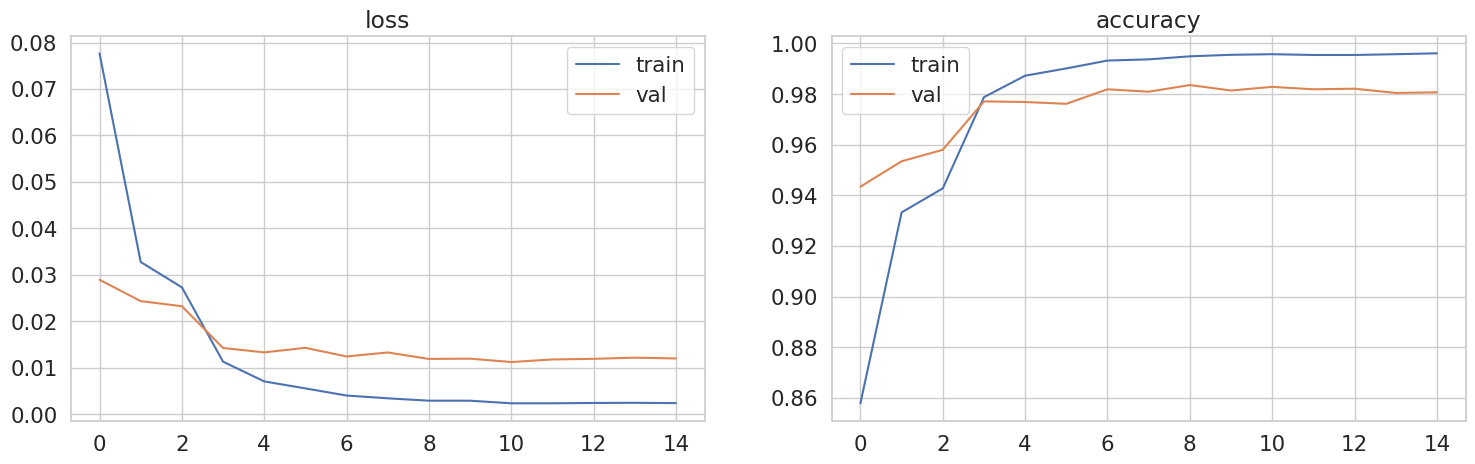

In [21]:
plot_metrics(losses_resnet, accs_resnet)

### Predictions

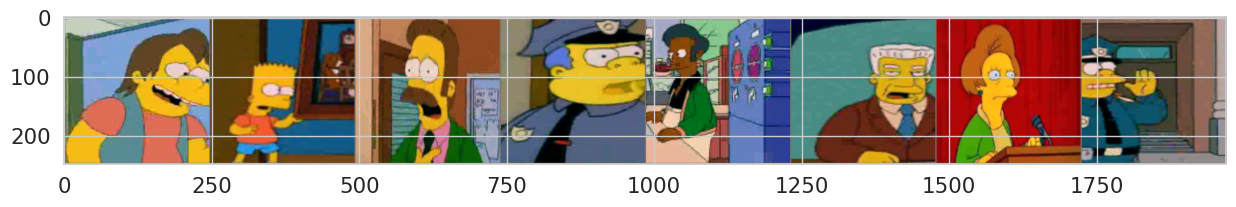

In [22]:
inputs, classes = next(iter(dataloader_test))
out = torchvision.utils.make_grid(inputs)

imshow(out)

In [23]:
probs_resnet = predict(model_resnet, dataloader_test)
print(probs_resnet.shape)

preds_resnet = np.argmax(probs_resnet, axis=1)
preds_resnet = class_names[preds_resnet]

pred_data = pd.read_csv('sample_submission.csv')
pred_data = pd.DataFrame({'id': test_filenames, 'Expected': preds_resnet}).sort_values('id')
pred_data.to_csv('./pred_data.csv', index=False)

pred_data

  0%|          | 0/124 [00:00<?, ?it/s]

probs shape before softmax: 124
probs shape after softmax: (991, 1000)
(991, 1000)


,id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon
...,...,...
986,img987.jpg,nelson_muntz
987,img988.jpg,ned_flanders
988,img989.jpg,charles_montgomery_burns
989,img99.jpg,chief_wiggum


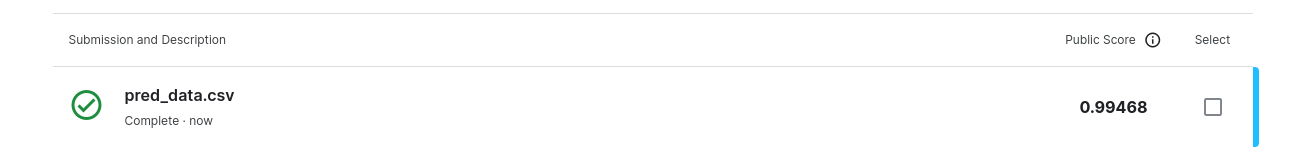